# Ограниченная линейная регрессия с помощью координатного спуска
*Строим линейную регрессию с неотрицательными коэффициентами, используя только *```numpy```*!*

Этот блокнот мотивирован задачей [неотрицательной линейной регрессии](http://en.wikipedia.org/wiki/Non-negative_least_squares). 

Обычно, когда вы строите линейную регрессию, вы позволяете коэффициентам быть какими угодно. Но иногда вы точно заранее знаете, что коэффициенты должны быть неотрицательны, есть тому физические или экономические причины. 

Например, в Альфа-Банке я строил модель вероятности дефолта на базе созданных кем-то экспертных правил ("fraud-триггеров"), которые были заранее размечены как позитивные и негативные. Все коэффициенты регрессии, которые таким ожиданиям не соответствуют, хочется занулять, а остальные - пересчитывать.  

В таких случаях можно запариться и оценивать [байесовскую регрессию](http://en.wikipedia.org/wiki/Bayesian_linear_regression). Но если по каким-то причинам лень, можно решать обычную задачу МНК, потребовав, чтобы коэффифиценты были неотрицательные. 

Модель ```Lasso``` из ```scikit-learn``` уже может требовать неотрицательности коэфффициентов. Основана она на алгоритме [координатного спуска](https://en.wikipedia.org/wiki/Coordinate_descent). Мы можем реализовать его самостоятельно, используя покоординатный [метод Ньютона](http://en.wikipedia.org/wiki/Newton%27s_method_in_optimization). 

Работает метод Ньютона очень просто: для параболы $y=f(x)=ax^2+bx+c$ вершина находится в $\frac{-b}{2a}$, и в эту вершину можно сразу шагать, чтобы прийти к оптимуму. 

Если функция $f(x)$ нелинейная, её можно разложить в ряд Тейлора $f(x)\approx \frac{f^{''}(x_0)}{2}(x-x_0)^2+f^{'}(x_0)(x-x_0)+f(x_0)$ в точке $x_0$, и попробовать шагнуть в точку $x_1 = x_0 - \frac{f^{'}(x_0)}{f^{''}(x_0)}$. Там будет минимум параболы, но не факт, что минимум самой $f$. Не страшно! Повторим попытку из $x_1$, и рано или поздно мы доберёмся до максимума. Ну, а в задаче МНК $f$ действительно парабола, так что к оптимуму мы придём сразу. 

Если $x$ многомерная, то вместо $\frac{f^{'}(x_0)}{f^{''}(x_0)}$ используется вектор $g_f(x_0)H^{-1}_f(x_0)$, где $g$ -вектор первых производных $f$, а $H$ - матрица вторых производных. 

Если бы в задаче не было ограничений, то $gH^{-1}$ мне было бы достаточно для счастья. Но делая такой шаг, можно выйти за ограничение. Поэтому я буду брать по одной координате, и идти в направлении $gH^{-1}$, пока не дойду до минимума по этой координате или до ограничения. Пройдя так через все координаты по нескольку раз, я обезательно дойду до оптимума. 

Вот пример модельки. Для простоты, я не включал в модель свободный член:

In [1]:
import numpy as np
# генерируем данные - центрированную линейную регрессию
np.random.seed(1)
n = 1000
X = np.random.normal(size=(n, 10))
y = np.dot(X, [0,0,0,0,0,1,2,3,4,5]) + np.random.normal(size=n, scale=3) # я точно знаю, что истинные координаты неотрицательные

Начнём с решения обычного МНК, ограничим его, и найдём оптимальные коэффициенты координатным спуском. 

Всё отрицательное стало нулевым, а положительное немножко под это подстроилось. 

In [2]:
%%time
# начальное решение неограниченным МНК (часть координат отрицательные)
beta = np.dot(np.linalg.inv(np.dot(X.transpose(),X)), np.dot(X.transpose(), y))
print(beta.round(3))
# запоминаем, где мы были на предыдущем шаге
prev_beta = beta.copy()
# ограничим решение нулём снизу
beta = np.maximum(beta, 0)
# запустим покоординатный метод Ньютона
hessian = np.dot(X.transpose(), X) # это матрица всех вторых производных
# крутим алгоритм, пока бета не перестанет меняться
while not (np.abs(prev_beta - beta)<1e-20).all():
    prev_beta = beta.copy()
    for i in range(len(beta)):
        gradient = np.dot(np.dot(X,beta)-y, X) # а это вектор всех первых производных
        beta[i] = np.maximum(0, beta[i] - gradient[i] / hessian[i,i]) # обновление
print(beta.round(3))

[-0.029 -0.043  0.05  -0.042 -0.09   0.834  1.947  3.177  4.091  5.138]
[ 0.     0.     0.05   0.     0.     0.838  1.944  3.181  4.089  5.136]
Wall time: 13.1 ms


Можно попытаться увеличить скорость алгоритма, рассчитывая не весь градиент, а только одну его координату за раз. В этом случае оказывается, что координатный спуск часто в несколько раз быстрее обычного градиентного спуска, которым обучают нейросети!

С 10 координатами это сокращает время примерно на треть, но в более многомерном случае экономия была бы более существенной. 

Пробуем:

In [3]:
%%time
beta = np.dot(np.linalg.inv(np.dot(X.transpose(),X)), np.dot(X.transpose(), y))
print(beta.round(3))
prev_beta = beta.copy()
beta = np.maximum(beta, 0)
hessian = np.dot(X.transpose(), X)
resid = y - np.dot(X, beta)
while not (np.abs(prev_beta - beta)<1e-20).all():
    prev_beta = beta.copy()
    for i in range(len(beta)):
        derivative = np.dot(X[:,i], resid) / hessian[i,i]
        prev = beta[i]
        beta[i] = np.maximum(0, beta[i] + derivative)
        resid += X[:,i] * (prev-beta[i])
print(beta.round(3))

[-0.029 -0.043  0.05  -0.042 -0.09   0.834  1.947  3.177  4.091  5.138]
[ 0.     0.     0.05   0.     0.     0.838  1.944  3.181  4.089  5.136]
Wall time: 8 ms


Больше фактов, алгоритмов и ссылок есть в [презентации](http://www.cs.cmu.edu/~ggordon/10725-F12/slides/25-coord-desc.pdf) Тибширани, создателя Лассо-регрессии.

Здесь же хочется нарисовать картинку для двумерного случая. Начнём со случая, когда ограничения не активны:

[ 1.019  4.908]


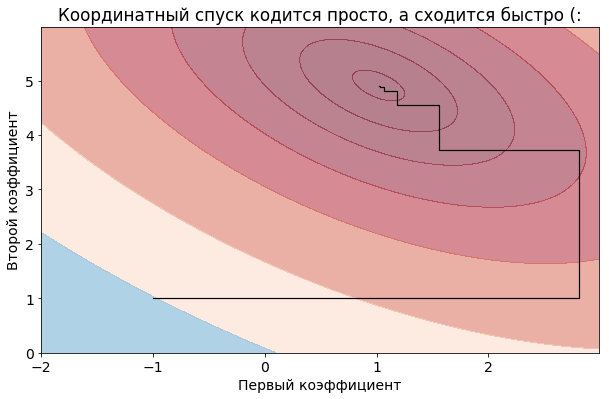

In [4]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

np.random.seed(1)
n = 1000
X = np.random.normal(size=(n, 2))
X[:,0]+=X[:,1] * 0.7 # correlated X for more fun!
y = np.dot(X, [1, 5]) + np.random.normal(size=n, scale=3)

beta = np.array([-1, 1]).astype(float)
prev_beta = beta + 1
# improve the solution by restricted coordinate-wise Newton descent
hessian = np.dot(X.transpose(), X)
betas = [beta.copy()]
while not (np.abs(prev_beta - beta)<1e-20).all():
    prev_beta = beta.copy()
    for i in range(len(beta)):
        grad = np.dot(np.dot(X,beta) - y, X)
        beta[i] = np.maximum(0, beta[i]-grad[i] / hessian[i,i])
        betas.append(beta.copy())
print(beta.round(3))
betas_history = np.vstack(betas)

h = 0.01
xx, yy = np.meshgrid(np.arange(-2, 3, h), np.arange(0, 6, h))
Z = np.mean((y[:, np.newaxis] - np.dot(X, np.vstack([xx.ravel(), yy.ravel()])))**2, axis=0)
Z = Z.reshape(xx.shape)
cm = plt.cm.RdBu
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, cmap=cm, alpha=0.5, levels=[8, 8.55, 9, 10, 12, 16, 25, 40, 70])

plt.plot(betas_history[:,0], betas_history[:,1], color='k', lw=1.2)
plt.xlabel('Первый коэффициент')
plt.ylabel('Второй коэффициент')
plt.title('Координатный спуск кодится просто, а сходится быстро (:');

А теперь посмотрим, как наш алгоритм обходит ограничения:

[ 0.     1.959]


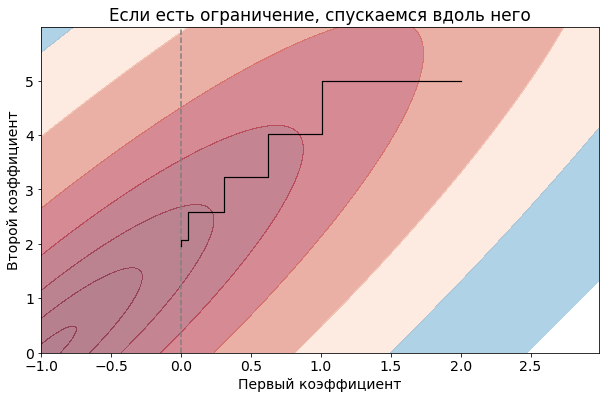

In [5]:
np.random.seed(1)
n = 1000
X = np.random.normal(size=(n, 2))
X[:,0]-=X[:,1] * 2 # correlated X for more fun!
y = np.dot(X, [-1, 0.001]) + np.random.normal(size=n, scale=3)

beta = np.array([2, 5]).astype(float)
prev_beta = beta + 1
# improve the solution by restricted coordinate-wise Newton descent
hessian = np.dot(X.transpose(), X)
betas = [beta.copy()]
while not (np.abs(prev_beta - beta)<1e-20).all():
    prev_beta = beta.copy()
    for i in range(len(beta)):
        grad = np.dot(np.dot(X,beta) - y, X)
        beta[i] = np.maximum(0, beta[i]-grad[i] / hessian[i,i])
        betas.append(beta.copy())
print(beta.round(3))
betas_history = np.vstack(betas)

h = 0.01
xx, yy = np.meshgrid(np.arange(-1, 3, h), np.arange(0, 6, h))
Z = np.mean((y[:, np.newaxis] - np.dot(X, np.vstack([xx.ravel(), yy.ravel()])))**2, axis=0)
Z = Z.reshape(xx.shape)
cm = plt.cm.RdBu
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, cmap=cm, alpha=0.5, levels=[8, 8.55, 9, 10, 12, 16, 25, 40, 70])

yl = plt.ylim()
plt.vlines(0, *yl, linestyle='--', color='grey')
plt.ylim(yl)

plt.plot(betas_history[:,0], betas_history[:,1], color='k', lw=1.2)
plt.xlabel('Первый коэффициент')
plt.ylabel('Второй коэффициент')
plt.title('Если есть ограничение, спускаемся вдоль него');